# Assignment 1: From Dirty Data to Predictive Models

Federico Giorgi (fg2617)

Titanic Survival Dataset

## Data Dictionary
- Survival: Survival, 0 = No, 1 = Yes  
- pclass: Ticket class, 1 = 1st, 2 = 2nd, 3 = 3rd  
- sex: Sex	
- Age: Age in years	
- sibsp: # of siblings / spouses aboard the Titanic	
- parch: # of parents / children aboard the Titanic	
- ticket: Ticket number	
- fare: Passenger fare	
- cabin: Cabin number	
- embarked: port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

<strong> Variable Notes </strong>   
pclass: A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them.

## Basics 

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import time
import warnings

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.metrics import accuracy_score, classification_report, make_scorer, precision_score, recall_score, f1_score, mean_squared_error, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold, KFold, learning_curve, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.calibration import calibration_curve
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB

warnings.filterwarnings('ignore')


In [69]:
df_train = pd.read_csv("./train.csv")
df_test = pd.read_csv("./test.csv")

## 1 Exploratory data analysis and visualization
### 1.1 Univariate Data Analysis

In [71]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
plt.hist(df_train["Survived"])

(array([549.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 342.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

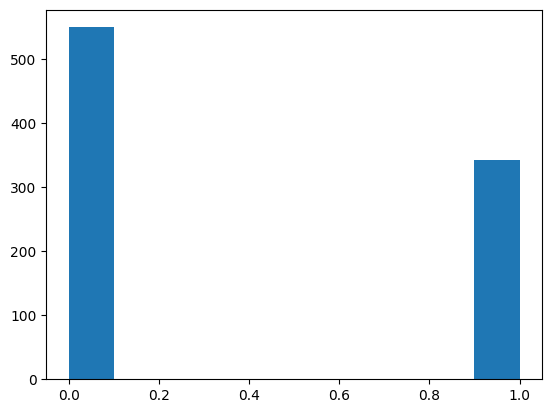

In [81]:
plt.hist(df_train["Survived"])

(array([216.,   0.,   0.,   0.,   0., 184.,   0.,   0.,   0., 491.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

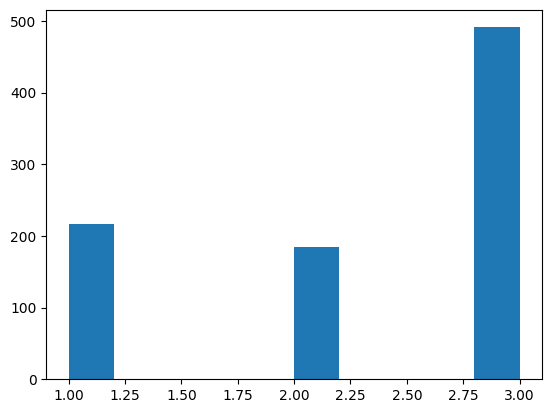

In [82]:
plt.hist(df_train["Pclass"])

(array([577.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 314.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

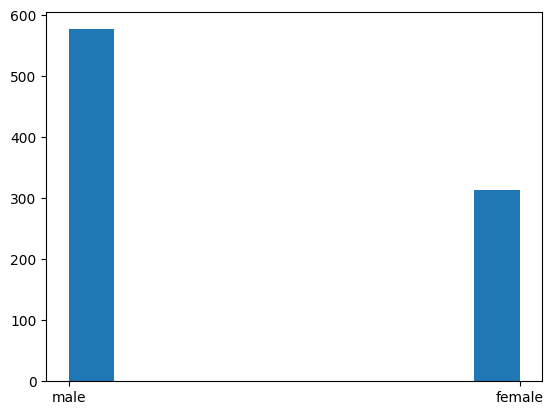

In [83]:
plt.hist(df_train["Sex"])

<Axes: xlabel='Age', ylabel='Density'>

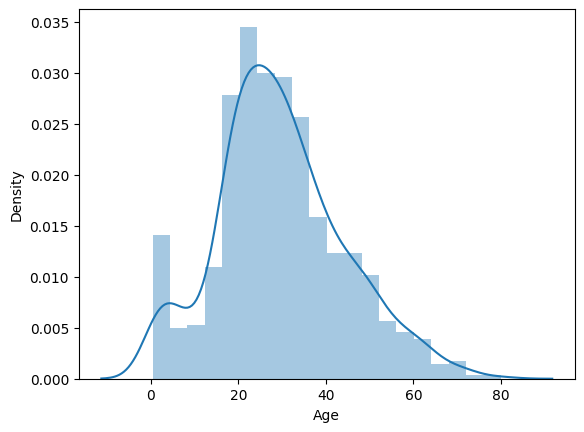

In [72]:
sns.distplot(df_train['Age'])

In [84]:
#SibSp

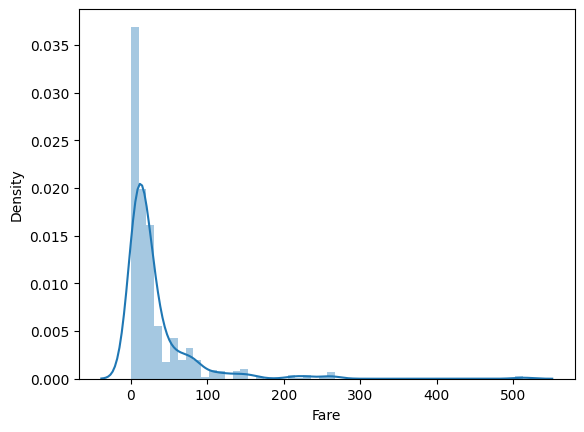

In [73]:
# plot the distribution of data
sns.distplot(df_train['Fare'])
plt.show()

<Axes: xlabel='Fare', ylabel='Density'>

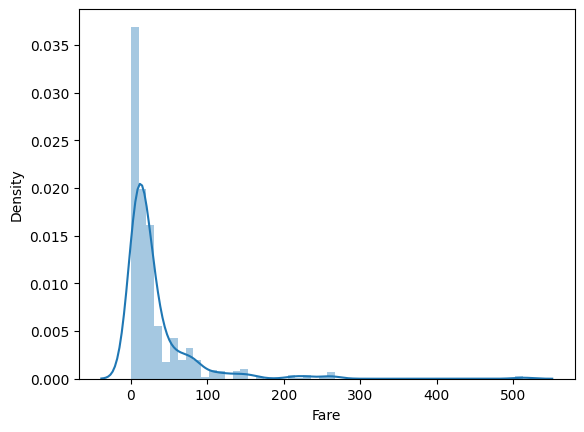

In [74]:
sns.distplot(df_train['Fare'])

### 1.2 Multivariate Data Analysis

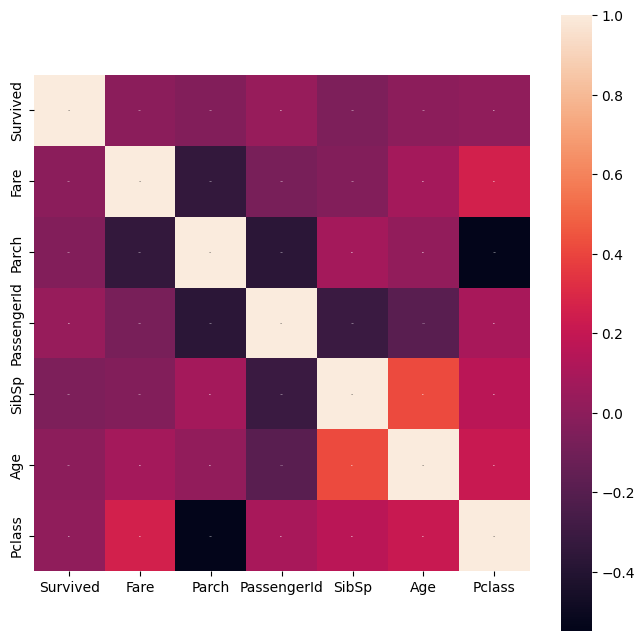

In [34]:
corrmat = df_train.corr(numeric_only=True)
f,ax=plt.subplots(figsize=(8,8))
k=10
cols=corrmat.nlargest(k,'Survived')['Survived'].index
sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 1}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

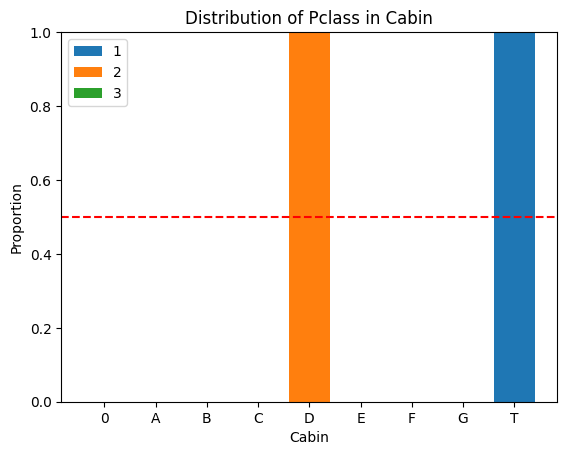

In [38]:
var = "Cabin"
ones = []
twos = []
threes = []
cabin = ["0", "A", "B", "C", "D", "E", "F", "G", "T"]

for i in cabin:
    data = df_train[df_train['Cabin'] == i]

    one = len(data[data["Pclass"] == 1])
    two = len(data[data["Pclass"] == 2])
    three = len(data[data["Pclass"] == 3])
    tot = one + two + three if one + two + three != 0 else 1  # to avoid division by zero
    ones.append(one / tot)
    twos.append(two / tot)
    threes.append(three / tot)

plt.bar(cabin, ones, label='1')
plt.bar(cabin, twos, label='2', bottom=ones)
plt.bar(cabin, threes, label='3', bottom=[i+j for i, j in zip(ones, twos)])
plt.axhline(y=0.5, color='red', linestyle='--')
plt.xlabel('Cabin')
plt.ylabel('Proportion')
plt.title(f'Distribution of Pclass in {var}')
plt.legend()
plt.show()

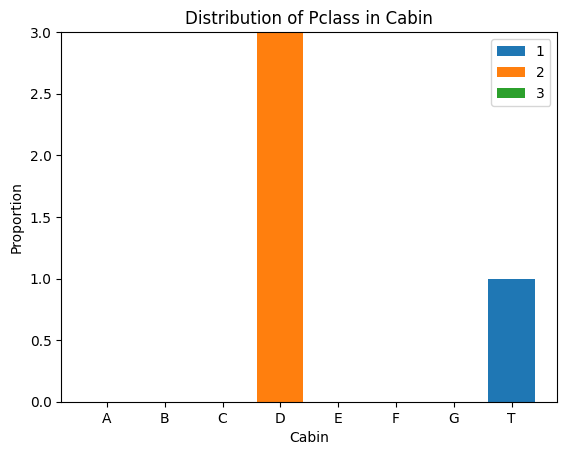

In [39]:
var = "Cabin"
ones = []
twos = []
threes = []
cabin = ["A", "B", "C", "D", "E", "F", "G", "T"]

for i in cabin:
    data = df_train[df_train['Cabin'] == i]

    one = len(data[data["Pclass"] == 1])
    two = len(data[data["Pclass"] == 2])
    three = len(data[data["Pclass"] == 3])
    ones.append(one)
    twos.append(two )
    threes.append(three)

plt.bar(cabin, ones, label='1')
plt.bar(cabin, twos, label='2', bottom=ones)
plt.bar(cabin, threes, label='3', bottom=[i+j for i, j in zip(ones, twos)])
plt.xlabel('Cabin')
plt.ylabel('Proportion')
plt.title(f'Distribution of Pclass in {var}')
plt.legend()
plt.show()

[0, 0, 0, 0, 2, 0, 0, 0, 0]


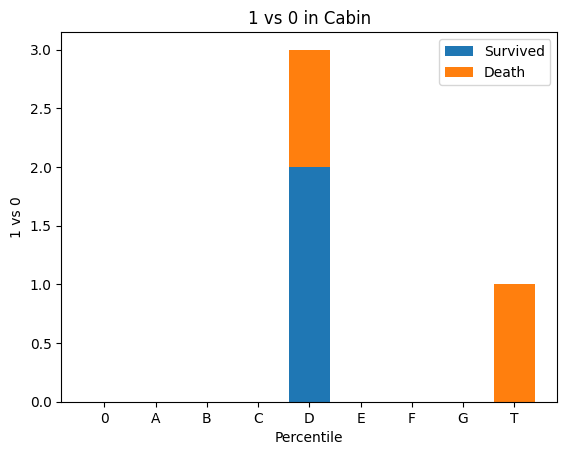

In [40]:
var = "Cabin"
ones = []
zeros = []
cabin = ["0","A","B","C","D","E","F","G","T"]

for i in cabin:
    data = df_train[df_train['Cabin'] == i]
    

    one = len(data[data["Survived"] == 1])
    zero = len(data[data["Survived"] == 0])
    ones.append(one)
    zeros.append(zero)

print(ones)

plt.bar(cabin, ones, label='Survived')
plt.bar(cabin, zeros, label='Death', bottom=ones)
plt.xlabel('Percentile')
plt.ylabel('1 vs 0')
plt.title(f'1 vs 0 in {var}')
plt.legend()
plt.show()

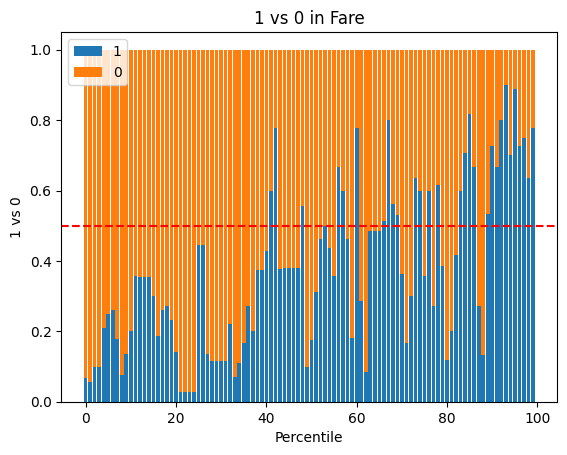

In [41]:
var = "Fare"
values = []
quantiles = []
ones = []
zeros = []

for i in range(0, 100):
    quantiles.append(i)
    quantile_i = df_train[var].quantile(i/100)
    quantile_i_1 = df_train[var].quantile((i+1)/100)
    df_quartile_i = df_train[(quantile_i_1 >= df_train[var]) & (df_train[var] >= quantile_i)]

    one = len(df_quartile_i[df_quartile_i["Survived"] == 1])
    zero = len(df_quartile_i[df_quartile_i["Survived"] == 0])
    tot = one + zero
    ones.append(one/tot)
    zeros.append(zero/tot)

plt.bar(quantiles, ones, label='1')
plt.bar(quantiles, zeros, label='0', bottom=ones)
plt.axhline(y=0.5, color='red', linestyle='--') 
plt.xlabel('Percentile')
plt.ylabel('1 vs 0')
plt.title(f'1 vs 0 in {var}')
plt.legend()
plt.show()

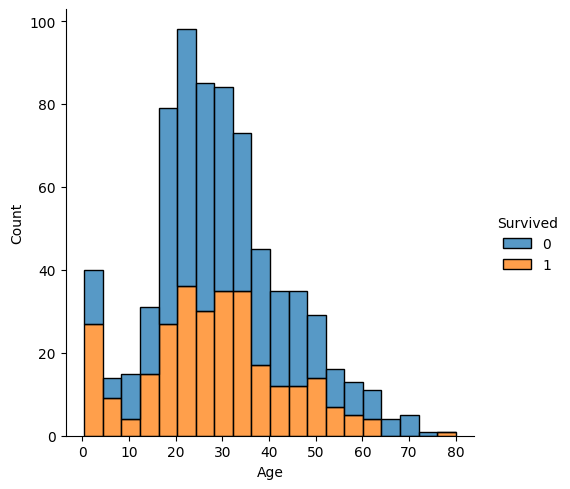

In [43]:
data = pd.concat([df_train['Survived'], df_train['Age']], axis=1)
sns.displot(data=data, x='Age', hue='Survived', multiple="stack")
plt.show()

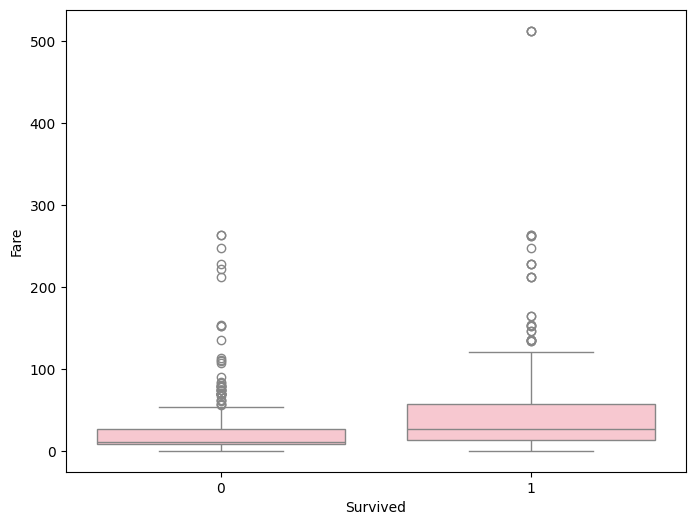

In [45]:
var = "Fare"
data = pd.concat([df_train['Survived'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(y=var, x="Survived", data=data, color="pink")

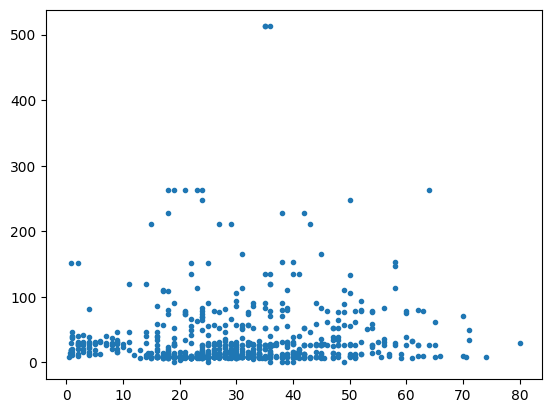

In [46]:
plt.plot(df_train['Age'], df_train['Fare'], '.')
plt.show()

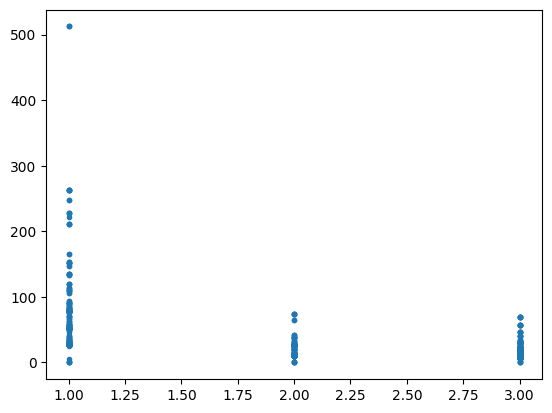

In [47]:
plt.plot(df_train['Pclass'], df_train['Fare'], '.')
plt.show()

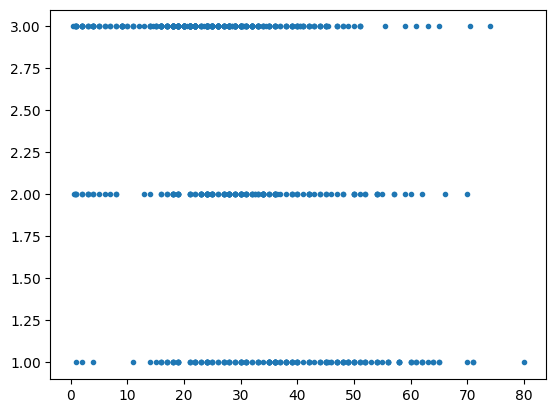

In [48]:
plt.plot(df_train['Age'], df_train['Pclass'], '.')
plt.show()

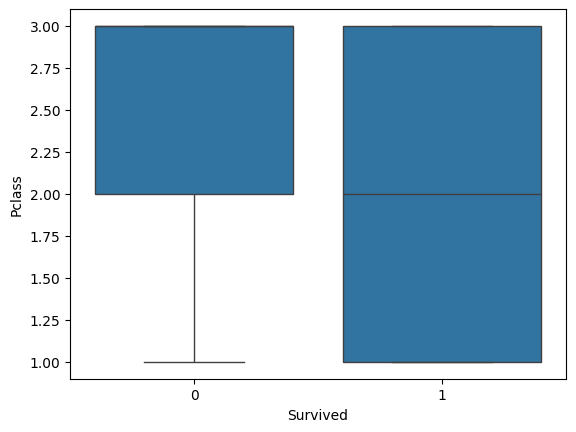

In [49]:
sns.boxplot(y = df_train['Pclass'], x = df_train['Survived'])
plt.show()

In [50]:
fare_scaled_train=StandardScaler().fit_transform(df_train['Fare'].values.reshape(-1,1))
df_train['Fare'] = fare_scaled_train.flatten()

## 2 Data Cleaning 

### 2.1 Missing Values

In [85]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum() / len(df_train)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['# Total', '% Total'])

missing_data.head(10)

,# Total,% Total
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000


## 3 Feature Engineering


In [53]:
#Family size
df_train['Family size'] = df_train['SibSp'] + df_train['Parch']

#Is alone
df_train['Is alone'] = 0
for i in range(0, 891):
    if df_train['Family size'][i] == 0:
        df_train['Is alone'][i] = 1

#Sex
df_train['Sex'] = df_train['Sex'].map({'male': 0, 'female': 1})

#Embarked
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

#Cabin
values = []
for i in range (0, 891):
    values.append('0')
    if type(df_train['Cabin'][i]) != float:
        values[i] = df_train['Cabin'][i][0]
df_train['Cabin'] = values
#df_train['Cabin'] = df_train['Cabin'].map({'0': 0,'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8})

#Tile
names = []
for name in range(891):
    title = df_train['Name'][name].split(',')[1].split('.')[0].strip()
    if title not in ('Mr', 'Mrs', 'Miss', 'Master'):
        title = 'Other'
    names.append(title)

df_train['Title'] = names
df_train['Title'] = df_train['Title'].map({'Mr': 0,'Mrs': 1, 'Miss': 2, 'Master': 3, 'Other': 4})

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family size,Is alone,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,-0.502445,0,2.0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,0.786845,C,0.0,1,0,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,-0.488854,0,2.0,0,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,0.420730,C,2.0,1,0,1
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,-0.486337,0,2.0,0,1,0


[0.29985443959243085, 0.4666666666666667, 0.7446808510638298, 0.5932203389830508, 0.7575757575757576, 0.75, 0.6153846153846154, 0.5, 0.0]


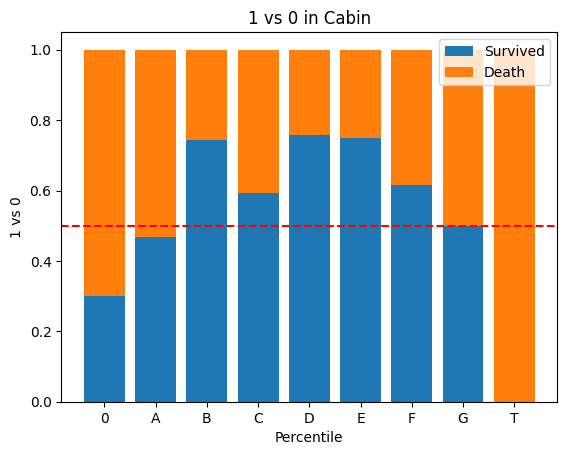

In [54]:
# plot the distribution of different instances of 'SeriousDlqin2yrs' (0 vs 1) through the different percentiles of the variable
var = "Cabin"
ones = []
zeros = []
cabin = ["0","A","B","C","D","E","F","G","T"]

for i in cabin:
    data = df_train[df_train['Cabin'] == i]
    

    one = len(data[data["Survived"] == 1])
    zero = len(data[data["Survived"] == 0])
    tot = one + zero
    ones.append(one/tot)
    zeros.append(zero/tot)

print(ones)

plt.bar(cabin, ones, label='Survived')
plt.bar(cabin, zeros, label='Death', bottom=ones)
plt.axhline(y=0.5, color='red', linestyle='--') 
plt.xlabel('Percentile')
plt.ylabel('1 vs 0')
plt.title(f'1 vs 0 in {var}')
plt.legend()
plt.show()

In [55]:
#Family size
df_test['Family size'] = df_test['SibSp'] + df_test['Parch']

#Is alone
df_test['Is alone'] = 0
for i in range(0, 418):
    if df_test['Family size'][i] == 0:
        df_test['Is alone'][i] = 1

#Sex
df_test['Sex'] = df_test['Sex'].map({'male': 0, 'female': 1})

#Embarked
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

#Cabin
values = []
for i in range (0, 418):
    values.append('0')
    if type(df_test['Cabin'][i]) != float:
        values[i] = df_test['Cabin'][i][0]
df_test['Cabin'] = values
df_test['Cabin'] = df_test['Cabin'].map({'0': 0,'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8})

#Tile
names = []
for name in range(0, 418):
    title = df_test['Name'][name].split(',')[1].split('.')[0].strip()
    if title not in ('Mr', 'Mrs', 'Miss', 'Master'):
        title = 'Other'
    names.append(title)

df_test['Title'] = names
df_test['Title'] = df_test['Title'].map({'Mr': 0,'Mrs': 1, 'Miss': 2, 'Master': 3, 'Other': 4})


df_test['Age'].fillna(df_test['Age'].median(), inplace=True)
df_test['Embarked'].fillna(df_test['Embarked'].median(), inplace=True)
df_test['Fare'].fillna(df_test['Fare'].median(), inplace=True)

fare_scaled_test=StandardScaler().fit_transform(df_test['Fare'].values.reshape(-1,1))
df_test['Fare'] = fare_scaled_test.flatten()


df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family size,Is alone,Title
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,-0.497413,0,1,0,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,-0.512278,0,2,1,0,1
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,-0.464100,0,1,0,1,0
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,-0.482475,0,2,0,1,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,-0.417492,0,2,2,0,1


## 4 Model training

In [56]:
df_train['Cabin'] = df_train['Cabin'].map({'0': 0,'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8})
df_train['Age'].fillna(df_train['Age'].median(), inplace=True)
df_train['Embarked'].fillna(df_train['Embarked'].median(), inplace=True)

In [57]:
#DIVIDING FEATURES FROM TARGET VARIABLE
X = df_train.drop(columns=["PassengerId",'Name', 'Ticket', 'Survived'])
y = df_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_pred = df_test.drop(columns=["PassengerId",'Name', 'Ticket'])

df_results = pd.DataFrame(columns=['Model', 'f1', 'precision', 'recall', 'accuracy'])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [58]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family size,Is alone,Title
0,3,0,22.0,1,0,-0.502445,0,2.0,1,0,0
1,1,1,38.0,1,0,0.786845,3,0.0,1,0,1
2,3,1,26.0,0,0,-0.488854,0,2.0,0,1,2
3,1,1,35.0,1,0,0.420730,3,2.0,1,0,1
4,3,0,35.0,0,0,-0.486337,0,2.0,0,1,0


### 4.1 Linear Regression

In [61]:
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [65]:
y_pred = np.round(y_pred)
y_pred

array([ 0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
       -0.,  1., -0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
        1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,
        1.,  1., -0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
        1.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,
        0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
        0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.])

#### 4.1.1 LASSO Regression (L1 regularization)

#### 4.1.2 Ridge Regression (L2 regularization)

### 4.2 Naive Bayes 

## 5 Model Evaluation

In [59]:
df_results.sort_values(by='f1', ascending=False)

,Model,f1,precision,recall,accuracy


In [60]:
df_results.set_index('Model', inplace=True)
ax = df_results.plot(kind='bar', figsize=(10, 6))

plt.title('Performance dei Modelli')
plt.xlabel('Modelli')
plt.ylabel('Punteggio')
plt.legend(title='Metriche')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

TypeError: no numeric data to plot

In [ ]:
predictions_df = pd.DataFrame(predictions_xgb, columns=['Survived'])
predictions_df['PassengerId'] = df_test['PassengerId']
predictions_df.to_csv('predictions.csv', index=False)

In [ ]:
predictions_df

,Survived,PassengerId
0,0,892
1,0,893
2,0,894
3,1,895
4,1,896
...,...,...
413,1,1305
414,1,1306
415,0,1307
416,1,1308
